In [36]:
import pandas as pd

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb

import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np

import matplotlib.pyplot as plt

## Imports

In [22]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)

In [23]:
# Load the data that was used to create simulations

i1 = 7436
i2 = 7565
# why this sometimes takes so long  - 5 minutes!!!
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
df_single_gal1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i1)+'.parquet')
df_single_gal2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)
df_single = pd.concat([df_single_ps1, df_single_ps2, df_single_gal1, df_single_gal2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
df_single_gal1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_flux_'+str(i1)+'.parquet')
df_single_gal2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)
df_single_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux, df_single_gal1_flux, df_single_gal2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')

df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

# Apply the filter to the dataframe
all_obj = df_single[
    (df_single['ra'] >= ra_min) & (df_single['ra'] <= ra_max) &
    (df_single['dec'] >= dec_min) & (df_single['dec'] <= dec_max)]

In [24]:
# query starts here
repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

In [25]:
# we will cut just one very small part of the sky to make the query faster
ra_min = 215.6
ra_max = 216.4
dec_min = -12.9
dec_max = -12.15

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value

In [26]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "raErr", 
            "decErr", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "visit",
            "detector",	
            "x",
            "xErr",
            "y",
            "yErr",
            "time_processed", 
            "time_withdrawn",
            "isDipole",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [27]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min_in_rad} AND {ra_max_in_rad}
        AND "dec" BETWEEN {dec_min_in_rad} AND {dec_max_in_rad}
        LIMIT 3000000;
    ''', connection)
    
srcForced4_field['ra'] = radians_to_degrees(srcForced4_field['ra'].values)
srcForced4_field['dec'] = radians_to_degrees(srcForced4_field['dec'].values)

In [28]:
#latest = False does not work
or4_obj = apdbQuery.load_objects(limit=1e7, latest=True)

# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7

In [29]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > ra_min) & (or4_obj['ra'] < ra_max) & (or4_obj['dec'] > dec_min) & (or4_obj['dec'] < dec_max)]
obj4_field

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
153210,3068394109505896606,2024-06-26 02:48:25+00:00,None,215.889039,NaN,-12.896901,NaN,NaN,60487.114560,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,5
153235,3068394109505896635,2024-06-26 02:52:34+00:00,None,215.948394,2.019397e-05,-12.894802,9.924860e-06,-1.183491e-10,60487.117363,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:51:18+00:00,7
153238,3068394109505896638,2024-06-26 02:54:17+00:00,None,215.922383,5.851012e-07,-12.885339,6.303400e-07,1.301129e-14,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,23
153239,3068394109505896639,2024-06-26 02:58:21+00:00,None,215.966875,8.505353e-06,-12.899532,1.858597e-05,9.602694e-11,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,15
153244,3068394109505896644,2024-06-26 02:50:38+00:00,None,215.937075,NaN,-12.884774,NaN,NaN,60487.115963,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171475,3068394172890218525,2024-06-26 02:55:53+00:00,None,215.635087,NaN,-12.360875,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171477,3068394172890218554,2024-06-26 02:55:53+00:00,None,215.690908,3.625022e-05,-12.306796,2.220503e-05,4.035649e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171478,3068394172890218581,2024-06-26 02:55:53+00:00,None,215.665284,2.192825e-05,-12.264642,4.064201e-05,-5.401110e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171479,3068394172890218585,2024-06-26 02:55:53+00:00,None,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


In [30]:
nv_collections = ['LSSTComCamSim/runs/nightlyValidation/20240625/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240626/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240627/w_2024_25/DM-44966']
drp_collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25',
                  'LSSTComCamSim/prompt/output-2024-06-26',
                  'LSSTComCamSim/prompt/output-2024-06-27']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

## Lets look at flux

In [31]:
# select one object

diaObjectId = 3068394109535256631

single_src = src4_field[src4_field['diaObjectId'] == diaObjectId].iloc[0]
# single_src = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[25]

visit_id = single_src['visit']

# visit_id = 7024062500249
detector_id = single_src['detector']
print(visit_id, detector_id, single_src['band'], single_src['ra'], single_src['dec'])

one_pp_diaSrcTable = pp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': detector_id, 'visit': visit_id})
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId={'detector': detector_id, 'visit': visit_id})

one_pp_science = pp_butler.get('initial_pvi', dataId={'detector': detector_id, 'visit': visit_id})
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': detector_id, 'visit': visit_id})

7024062500190 7 i 215.97777807280704 -12.439841433860716


In [42]:
# this is just helper functions
band = src4_field[src4_field['diaObjectId']==diaObjectId]['band']
unique_bandsForced = bandForced.unique()
unique_bands = band.unique()
# find the earliest observation, so we can normalize to it
min_mjd = src4_field['midpointMjdTai'].min()

In [32]:
# match the observations to the truth
tru_obj = all_obj
match_value = 1
# single object that we are looking for 
dia_obj_SC = SkyCoord(ra=single_src['ra']*u.degree, dec=single_src['dec']*u.degree) 
# all of the objects in a field
tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
# match the observations to the truth
idx, d2d, d3d = dia_obj_SC.match_to_catalog_sky(tru_obj_SC)
# index of all diaObj that are within match_value of a true variable object
# idx_close = idx[d2d.to(u.arcsec).value<match_value]
print(np.min(d2d.to(u.arcsec).value))
# all of diaObjects thare are within match_value of a variable object
matches_close = tru_obj.iloc[idx]
matches_close

0.10293407127086265


object_type                                                      star
id                                                          930623123
ra                                                         215.977789
dec                                                        -12.439868
host_galaxy_id                                                    0.0
magnorm                                                      18.34446
sed_filepath                starSED/kurucz/km20_6000.fits_g25_6160.gz
MW_rv                                                             3.1
MW_av                                                        0.274954
mura                                                            -8.41
mudec                                                           -2.27
radial_velocity                                                -26.99
parallax                                                     0.161957
variability_model                                                    
salt2_params        

In [33]:
# magnitude calculation
df_single_flux_src = df_single_flux[df_single_flux['id']==matches_close['id']]
df_single_mag_src = flux_to_magnitude(df_single_flux_src)

In [34]:
# the offest due to variability
mjd0 = 60400
mjd = src4_field[src4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
period = matches_close['period']
phase = matches_close['phase']
mag_amplitude = matches_close['mag_amplitude']
mag_amplitude*np.sin(2.*np.pi*(mjd - mjd0)/period + phase)

964      0.751222
2101     0.751406
4130     0.751497
5487     0.751587
7137     0.751677
9585     0.752366
10243    0.752449
11808    0.752532
13824    0.753454
14544    0.753527
15480    0.753599
16197    0.753671
17374    0.753742
18244    0.753812
21035    0.754017
23280    0.754151
23964    0.754217
24884    0.754282
25668    0.754347
28045    0.754473
29259    0.754711
30423    0.754837
33036    0.755009
35152    0.755120
36667    0.755174
37564    0.755228
39643    0.755281
41074    0.755333
42348    0.755384
43589    0.755434
44750    0.755484
45520    0.755534
47227    0.755630
48667    0.755678
49813    0.755724
50430    0.752853
52739    0.753305
53718    0.752613
55200    0.752694
Name: midpointMjdTai, dtype: float64

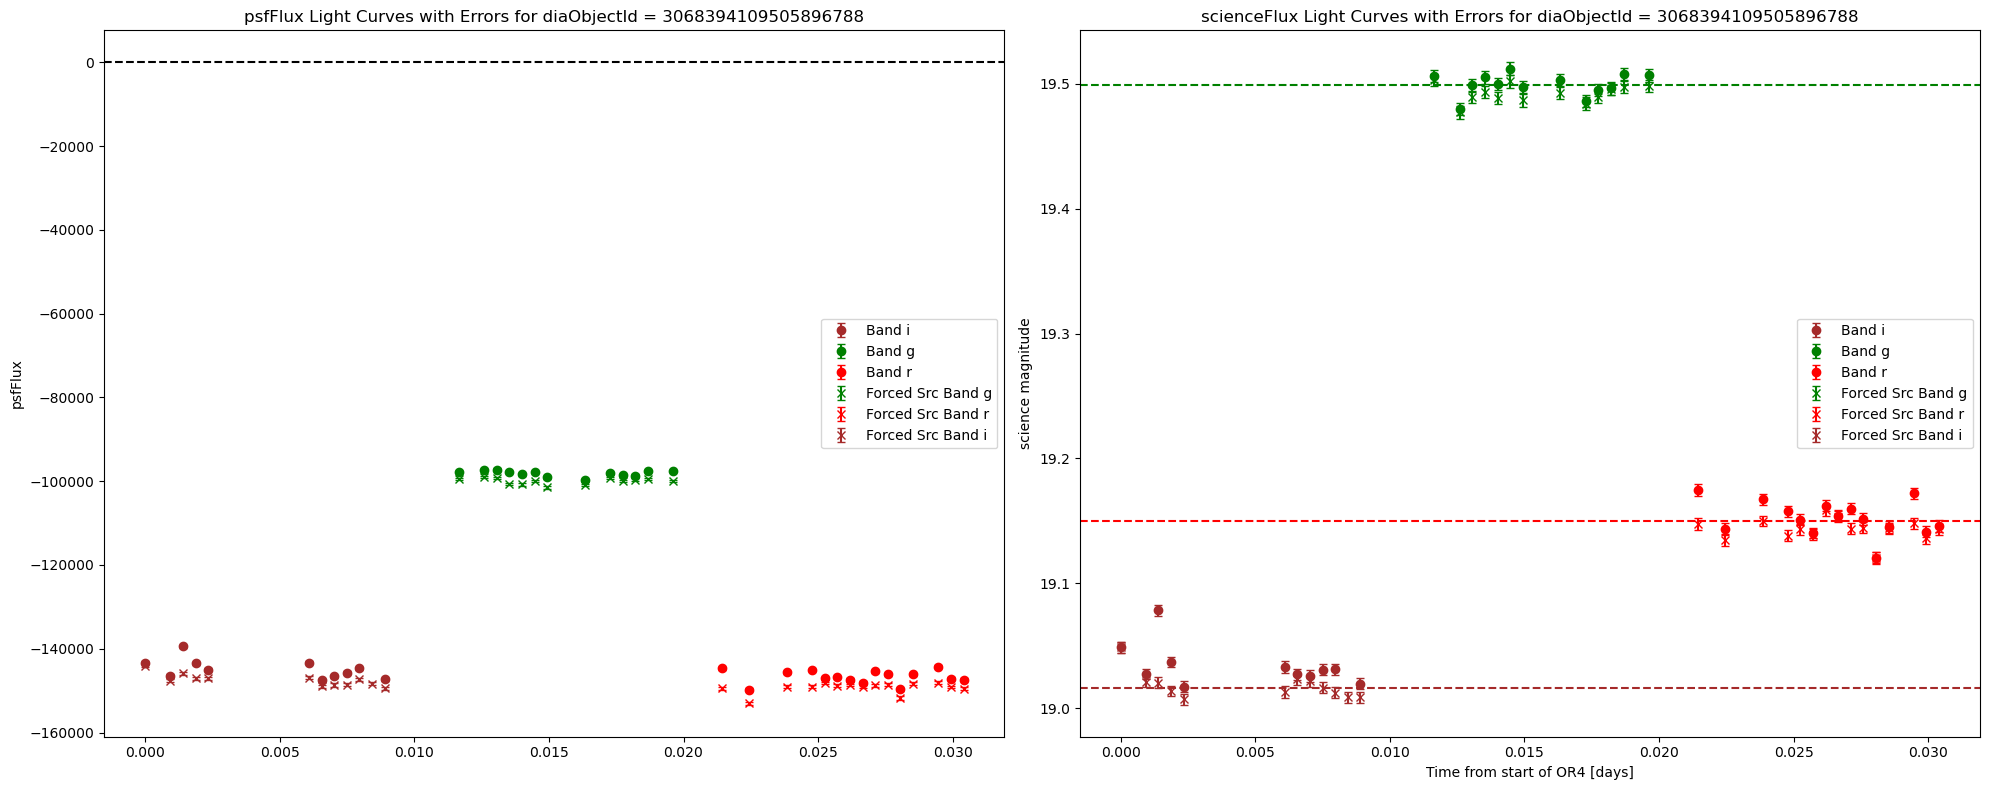

In [43]:
# Filter the data for the specific diaObjectId
mjd = src4_field[src4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
psfFlux = src4_field[src4_field['diaObjectId'] == diaObjectId]['psfFlux']
psfFluxErr = src4_field[src4_field['diaObjectId'] == diaObjectId]['psfFluxErr']
band = src4_field[src4_field['diaObjectId'] == diaObjectId]['band']
scienceFlux = src4_field[src4_field['diaObjectId'] == diaObjectId]['scienceFlux']
scienceFluxErr = src4_field[src4_field['diaObjectId'] == diaObjectId]['scienceFluxErr']

# Filter the forced data for the specific diaObjectId
mjdForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
psfFluxForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['psfFlux']
psfFluxErrForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['psfFluxErr']
bandForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['band']
scienceFluxForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['scienceFlux']
scienceFluxErrForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['scienceFluxErr']

# Define a dictionary to map bands to colors
band_colors = {
    'g': 'green',
    'r': 'red',
    'i': 'brown'
}

# Create a figure with two subplots (panels)
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

# Plot psfFlux in the first subplot
for b in unique_bands:
    band_mask = band == b
    color = band_colors.get(b, 'blue')  # Default color if not in dictionary
    axs[0].errorbar(mjd[band_mask] - min_mjd, psfFlux[band_mask], yerr=psfFluxErr[band_mask],
                    label=f'Band {b}', fmt='o', capsize=3, color=color)

for b in unique_bandsForced:
    band_mask_forced = bandForced == b
    color = band_colors.get(b, 'blue')  # Default color if not in dictionary
    axs[0].errorbar(mjdForced[band_mask_forced] - min_mjd, psfFluxForced[band_mask_forced], yerr=psfFluxErrForced[band_mask_forced],
                    label=f'Forced Src Band {b}', fmt='x', capsize=3, color=color)

# Add labels and title for psfFlux panel
axs[0].set_ylabel('psfFlux')
axs[0].set_title('psfFlux Light Curves with Errors for diaObjectId = 3068394109505896788')
axs[0].legend()
axs[0].axhline(0, color='black', linestyle='--')

# Plot scienceFlux in the second subplot
for b in unique_bands:
    band_mask = band == b
    science_mag, science_mag_err = create_mag_errors(scienceFlux[band_mask], scienceFluxErr[band_mask])
    color = band_colors.get(b, 'blue')  # Default color if not in dictionary
    axs[1].errorbar(mjd[band_mask] - min_mjd, science_mag, yerr=science_mag_err,
                    label=f'Band {b}', fmt='o', capsize=3, color=color)

for b in unique_bandsForced:
    band_mask_forced = bandForced == b
    science_mag_force, science_mag_err_force = create_mag_errors(scienceFluxForced[band_mask_forced], scienceFluxErrForced[band_mask_forced])
    color = band_colors.get(b, 'blue')  # Default color if not in dictionary
    axs[1].errorbar(mjdForced[band_mask_forced] - min_mjd, science_mag_force, yerr=science_mag_err_force,
                    label=f'Forced Src Band {b}', fmt='x', capsize=3, color=color)

# Add labels and title for scienceFlux panel
axs[1].set_xlabel('Time from start of OR4 [days]')
axs[1].set_ylabel('science magnitude')
axs[1].set_title('scienceFlux Light Curves with Errors for diaObjectId = 3068394109505896788')
axs[1].legend()

# Plot horizontal lines for reference magnitudes (use 0.75 offset for variability)
axs[1].axhline(df_single_mag_src['mag_i'].values[0]+0.75, color='brown', linestyle='--')
axs[1].axhline(df_single_mag_src['mag_g'].values[0]+0.75, color='green', linestyle='--')
axs[1].axhline(df_single_mag_src['mag_r'].values[0]+0.75, color='red', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()